## Import required modules.

Import all modules required for assignment.

In [1]:
# Import required modules for assignment.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import mahotas
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

## Import training dataset.

In [2]:
# Import the training set CSV file.  Show head.

train_df = pd.read_csv('trainset_students.csv')
train_df.head()

,ID,Label,Label_Confidence
0,818021711,Positive,0.6715
1,911806503,Positive,0.6642
2,882035319,Negative,0.6683
3,880892525,Neutral,0.3360
4,828003448,Positive,1.0000


In [3]:
# Have a look at the shape of the dataframe.
train_df.shape

(9437, 3)

Training dataset have three columns, one for photo ID, Label and the Label_Confidence.  Training set contains 9437 observations.

## EDA.

Create a bar graph to see how balances the classes are in our data set.

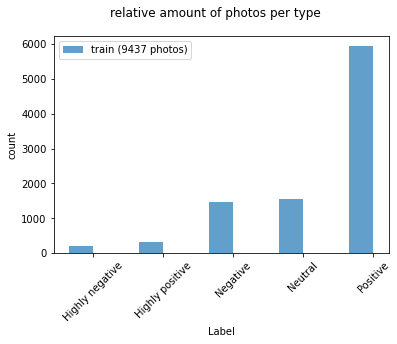

In [4]:
# Check to see how balanced our data is.
# let's see the label distribution
def plot_bar(y, col_name):
    width = 0.35
    n = -0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel(col_name)
    plt.ylabel('count')

plt.suptitle('relative amount of photos per type')
plot_bar(train_df['Label'], 'Label')
plt.legend([
    'train ({0} photos)'.format(len(train_df['Label']))
]);

Positive class is the majority class in this case.  Highly positive and highly negative e

In [5]:
# Create a table containing the proportions of each class.

tab = pd.crosstab(train_df['Label'], columns='count')

round(tab/tab.sum()*100)

col_0,count
Label,
Highly negative,2.0
Highly positive,3.0
Negative,15.0
Neutral,16.0
Positive,63.0


Exact distribution of each class within the training set.

In [6]:
# Gather some statistics on the training set.

# Define a function to put together statistics.
def get_statistics(df_inp, column_name):
    df_copy = df_inp.copy()
    print(f"Mean {column_name}: ", np.round(df_copy[column_name].mean(), 3))
    print(f"Standard Deviation in {column_name}: ", np.round(df_copy[column_name].std(),4))
    print(f"Median {column_name}: ", np.round(df_copy[column_name].median(), 3))
    print(f"Max {column_name}: ", df_copy[column_name].max())
    print(f"Min {column_name}: ", df_copy[column_name].min())
    
get_statistics(train_df,'Label_Confidence')

Mean Label_Confidence:  0.737
Standard Deviation in Label_Confidence:  0.2087
Median Label_Confidence:  0.67
Max Label_Confidence:  1.0
Min Label_Confidence:  0.3333


Statistics for the Label_Confidence column.  Shows that value is between 1 and 0.33, and on average is 0.737.

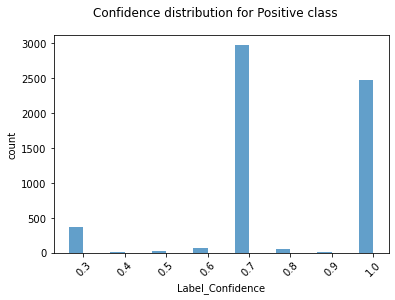

In [7]:
# View histogram for Positive label.
train_df_positive = train_df[train_df['Label']=='Positive']

plt.suptitle('Confidence distribution for Positive class')
plot_bar(round(train_df_positive['Label_Confidence'],1), 'Label_Confidence')

Bar graph above shows that people are usually fairly certain when an image is positive.

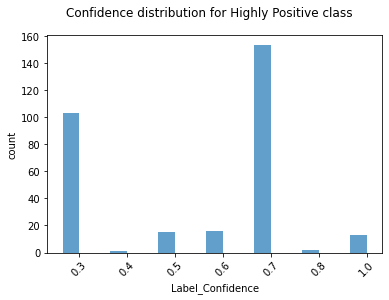

In [8]:
# View histogram for Highly positive label.
train_df_highly_positive = train_df[train_df['Label']=='Highly positive']

plt.suptitle('Confidence distribution for Highly Positive class')
plot_bar(round(train_df_highly_positive['Label_Confidence'],1), 'Label_Confidence')

People are less certain when the class is 'Highly positive'

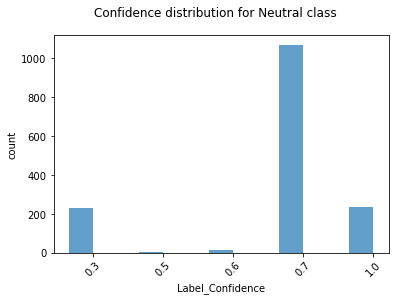

In [9]:
# View histogram for neutral label.
train_df_neutral = train_df[train_df['Label']=='Neutral']

plt.suptitle('Confidence distribution for Neutral class')
plot_bar(round(train_df_neutral['Label_Confidence'],1), 'Label_Confidence')

People fairly certain about a Neutral class image.

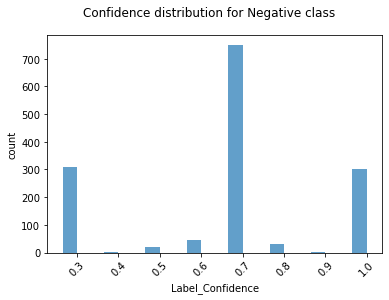

In [10]:
# View histogram for negative label.
train_df_negative = train_df[train_df['Label']=='Negative']

plt.suptitle('Confidence distribution for Negative class')
plot_bar(round(train_df_negative['Label_Confidence'],1), 'Label_Confidence')

Generally people are fairly certain about a negative image, but there seems to be a fair few images people aren't sure about.

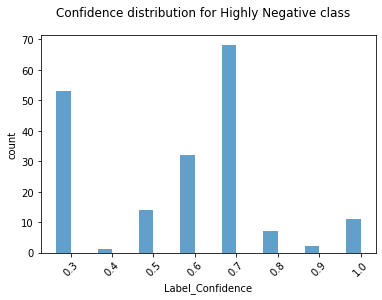

In [11]:
# View histogram for highly negative label.
train_df_highly_negative = train_df[train_df['Label']=='Highly negative']

plt.suptitle('Confidence distribution for Highly Negative class')
plot_bar(round(train_df_highly_negative['Label_Confidence'],1), 'Label_Confidence')

A lot of uncertainty regarding the very negative image.

In [12]:
# Calculate Mean and Std Deviation for the five classes.
train_df_positive['Label_Confidence'].mean()
train_df_highly_positive['Label_Confidence'].mean()
train_df_neutral['Label_Confidence'].mean()
train_df_negative['Label_Confidence'].mean()
train_df_highly_negative['Label_Confidence'].mean()

train_df_count = {'Stat':'Count',
                'Positive':train_df_positive['Label_Confidence'].count(),
                'Neutral':train_df_neutral['Label_Confidence'].count(),
                'Negative':train_df_negative['Label_Confidence'].count(),
                'Highly Negative':train_df_highly_negative['Label_Confidence'].count(),
                'Highly Positive':train_df_highly_positive['Label_Confidence'].count()}

train_df_mean = {'Stat':'Mean',
                'Positive':train_df_positive['Label_Confidence'].mean(),
                'Neutral':train_df_neutral['Label_Confidence'].mean(),
                'Negative':train_df_negative['Label_Confidence'].mean(),
                'Highly Negative':train_df_highly_negative['Label_Confidence'].mean(),
                'Highly Positive':train_df_highly_positive['Label_Confidence'].mean()}

train_df_stddev = {'Stat':'Std Dev',
                'Positive':train_df_positive['Label_Confidence'].std(),
                'Neutral':train_df_neutral['Label_Confidence'].std(),
                'Negative':train_df_negative['Label_Confidence'].std(),
                'Highly Negative':train_df_highly_negative['Label_Confidence'].std(),
                'Highly Positive':train_df_highly_positive['Label_Confidence'].std()}

train_df_sum = []
train_df_sum.append(train_df_count)
train_df_sum.append(train_df_mean)
train_df_sum.append(train_df_stddev)

train_df_sum = pd.DataFrame(train_df_sum)
train_df_sum

,Stat,Positive,Neutral,Negative,Highly Negative,Highly Positive
0,Count,5945.000000,1543.000000,1458.000000,188.000000,303.000000
1,Mean,0.786028,0.667348,0.665975,0.578648,0.558217
2,Std Dev,0.197685,0.182089,0.216491,0.183690,0.177621


Table above shows that the higher the counts for a specific class the higher the mean of the certainty.  Applies for all except for the Highly Negative and Positive classes which are other way around.  Put generally data shows the more extreme a classification is, the less certain the people surveyed about it are.

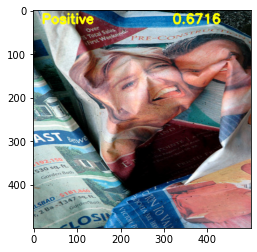

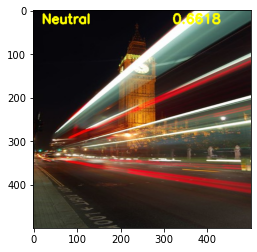

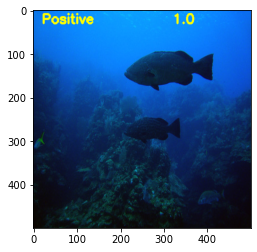

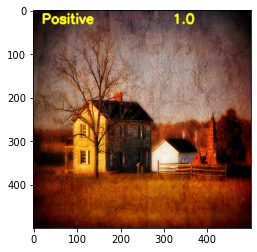

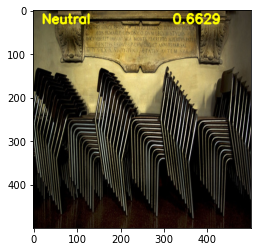

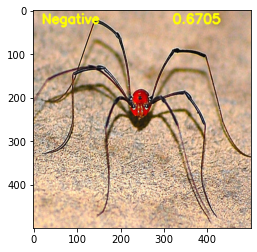

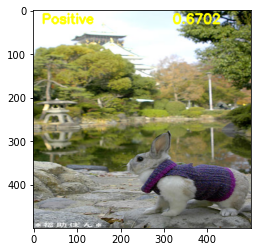

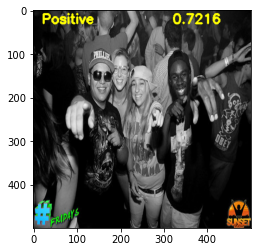

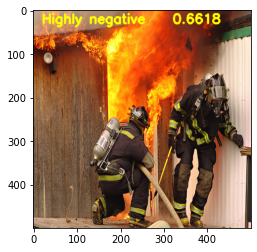

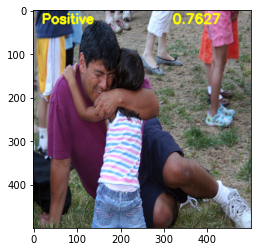

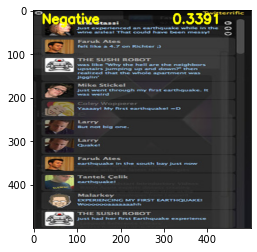

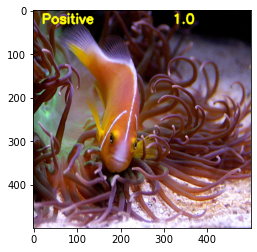

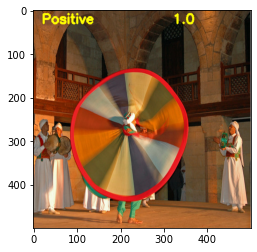

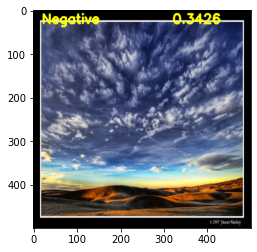

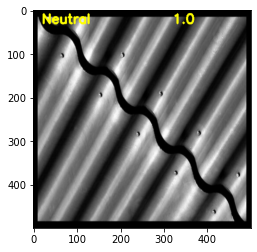

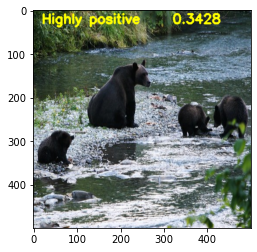

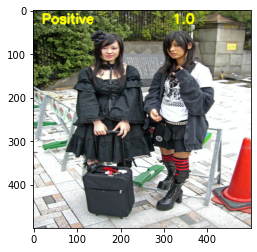

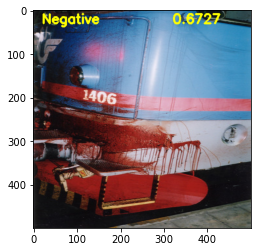

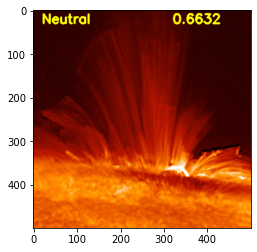

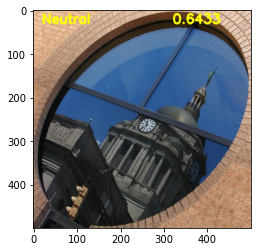

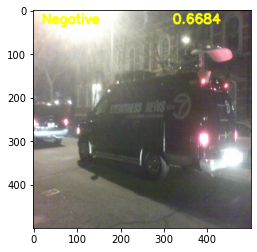

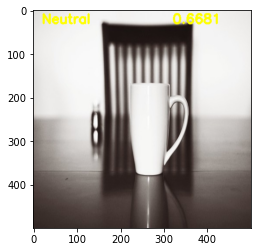

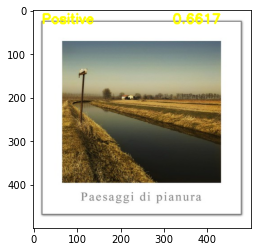

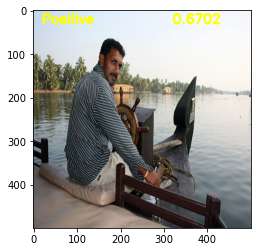

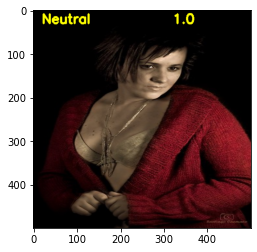

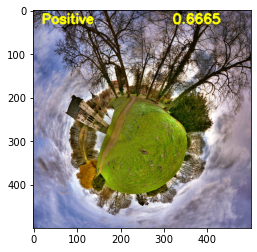

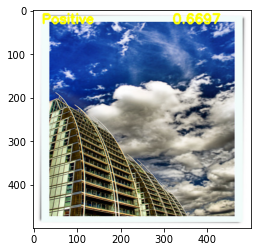

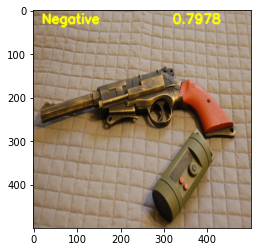

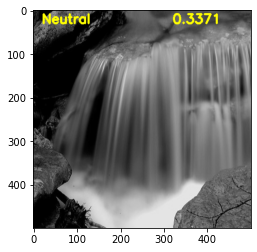

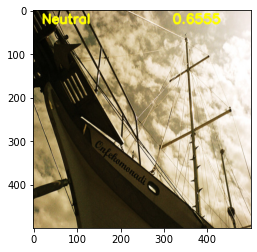

In [13]:
# show 30 random label on image
fixed_size = tuple((500, 500))
for i in np.random.randint(low=0, high = len(train_df), size=30):
    file = "images/" + str(train_df.iloc[i,0]) + ".jpg"
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    cv2.putText(image, train_df.iloc[i,1], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    cv2.putText(image, str(train_df.iloc[i,2]), (320,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

## Load functions required for feature extraction.

In [14]:
# feature-descriptor-1: Hu Moments
# here is more info about this feature
# https://learnopencv.com/shape-matching-using-hu-moments-c-python/
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
# here is more info about this feature
# https://www.nature.com/articles/s41598-017-04151-4

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
# here is more info about this feature
# https://en.wikipedia.org/wiki/Color_histogram
def fd_histogram(image, mask=None, bins = 8):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

# feature-descriptor-4: Colourfulness of image.
# https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
def fd_mnpxlval(image):
    blue, green, red = cv2.split(image)

    rg = np.absolute(red - green)

    yb = np.absolute(0.5 * (red + green) - blue)

    (rgMean, rgStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))

    stdRoot = np.sqrt((rgStd) ** 2) + (ybStd ** 2)
    meanRoot = np.sqrt((rgMean ** 2) + (ybMean ** 2))

    colourfulness = stdRoot + (0.3) * meanRoot

    outputList = []
    outputList.append(rgMean)
    outputList.append(rgStd)
    outputList.append(ybMean)
    outputList.append(ybStd)
    outputList.append(stdRoot)
    outputList.append(meanRoot)
    outputList.append(colourfulness)
    
    return outputList

## Extract features from Training set.

In [15]:
# to convert the input image to a fixed size of (500, 500).
# this can take a while on Colab beacuse of the I/O time (around 30 minutes, I stopped it after 20!)
fixed_size = tuple((500, 500))

# empty lists to hold feature vectors and labels
train_global_features = []
train_labels = []
train_confidence = []

train_hu_moments = []
train_haralick = []
train_histogram = []
train_mnpxlval = []

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)
    fv_mnpxlval = fd_mnpxlval(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_mnpxlval])
    #global_feature = np.hstack([fv_histogram, fv_hu_moments])

    # update the list of labels and feature vectors
    train_labels.append(row[1]['Label'])
    train_confidence.append(row[1]['Label_Confidence'])
    train_global_features.append(global_feature)
    
    train_hu_moments.append(fv_hu_moments)
    train_haralick.append(fv_haralick)
    train_histogram.append(fv_histogram)
    train_mnpxlval.append(fv_mnpxlval)
    
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(train_global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(train_labels).shape))

# encode the target labels
targetNames = np.unique(train_labels)
le = LabelEncoder()
target = le.fit_transform(train_labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(train_global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector size (9437, 539)
[STATUS] training Labels (9437,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [4 4 2 ... 4 0 4]
[STATUS] target labels shape: (9437,)


In [16]:
# Convert to dataframe to examine each feature individiually.
train_hu_moments = pd.DataFrame(train_hu_moments)
train_haralick = pd.DataFrame(train_haralick)
train_histogram = pd.DataFrame(train_histogram)
train_mnpxlval = pd.DataFrame(train_mnpxlval)

In [17]:
# Show shape of the hu_moments dataframe.
train_hu_moments.shape

(9437, 7)

Hu moments returns 7 features.

In [18]:
# Show shape of the haralick dataframe.
train_haralick.shape

(9437, 13)

Haralick returns 13 features.

In [19]:
# Show shape of the histogram dataframe.
train_histogram.shape

(9437, 512)

Colour histogram returns 512 features.

In [20]:
# Show shape of the mnxpxlval dataframe.
train_mnpxlval.shape

(9437, 7)

Colourfulness returns 7 features.

In [21]:
# Create a dataframe for the features generated in previous step.
prepared_X_train = pd.DataFrame(rescaled_features)

# Create a dataframe for the labels.
prepared_y_train = pd.DataFrame(target)
prepared_y_train = {'Label': target}
prepared_y_train = pd.DataFrame(prepared_y_train)

# Create a dataframe for the confidence associated with each label.
confidence = {'Conf': train_confidence}
confidence = pd.DataFrame(confidence)

# Create a new dataframe with the three dataframes combines.
prepared_train = [prepared_X_train, prepared_y_train, confidence]
prepared_train = pd.concat(prepared_train, axis=1)

The above will turn our extracted feature set into a dataframe containing all of our features, Label_confidence and the Label column.

In [22]:
# Define a function to calculate RSD for summary below.  Return 0 when mean is equal to 0.
def rsd_calc(std_dev, mean):
    try:
        rsd = (std_dev*100)/mean
        return rsd
    
    except ZeroDivisionError:
        rsd = 0
        return rsd

# Define a function to summarise the prepared_train dataset.
def get_statistics_df(df_inp):
    output_list = []
    
    for column in df_inp:
        temp_dict = {"Column":column,
                    "Mean":np.round(df_inp[column].mean(), 4),
                    "Std_Dev":np.round(df_inp[column].std(), 4),
                    "RSD":np.round(rsd_calc(df_inp[column].std(),df_inp[column].mean()), 2),
                    "Median":np.round(df_inp[column].median(), 4),
                    "Max":df_inp[column].max(),
                    "Min":df_inp[column].min()}
        output_list.append(temp_dict)
        
    output = pd.DataFrame(output_list)
    
    output = output.sort_values(by=['Std_Dev'], ascending=False)
    
    return output

prepared_train_stats = get_statistics_df(prepared_train)
prepared_train_stats

,Column,Mean,Std_Dev,RSD,Median,Max,Min
539,Label,3.3515,0.9843,29.37,4.0000,4.0,0.0
533,533,0.6097,0.2694,44.18,0.6885,1.0,0.0
0,0,0.1453,0.2616,179.99,0.0127,1.0,0.0
532,532,0.3892,0.2452,63.01,0.3694,1.0,0.0
7,7,0.1202,0.2112,175.67,0.0234,1.0,0.0
...,...,...,...,...,...,...,...
437,437,0.0000,0.0000,0.00,0.0000,0.0,0.0
438,438,0.0000,0.0000,0.00,0.0000,0.0,0.0
439,439,0.0000,0.0000,0.00,0.0000,0.0,0.0
440,440,0.0000,0.0000,0.00,0.0000,0.0,0.0


In [23]:
# Output the stats to a CSV file so they can be attached as an appendix.
prepared_train_stats.to_csv('prepared_train_stats.csv', index=False)

The above is a summary of our training dataset.  It has been sorted by standard deviation, highest to lowest.  Higher standard deviation means dataset contains more information.

## Create training/test split from training set.

In [24]:
# Split prepared train into a training set and a test set for optimising the models.  I have decided to make
# make a training and validation set over a stratified kfold as I'm not able to take sample weight into account
# when doing the kfold cross validation.

from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(prepared_train.iloc[:, 0:541],
                                                                prepared_train['Label'],
                                                                test_size=0.3, random_state=42)

#X_train.iloc[:, 0:539]
#Y_train

In [25]:
# Do a simple GridSearch to try and find most ideal hyperparameters.  Load the results into a dataframe so we can
# extract settings with maximum accuracy.

# Create lists to collect results.
rf_tune_criterion = []
rf_tune_boot = []
rf_tune_ntree = []
rf_tune_mdepth = []
rf_tune_min_split =[]
rf_tune_min_sleaf = []
rf_tune_accuracy = []

# List to set criterion to test.
criterion_list = ['entropy', 'gini']
bootstrap_list = [True,False]
min_samp_split_list = [2, 5, 10]
min_samp_leaf_list = [1, 2, 4]
n_tree_list = [50,100,250]
m_depth_list = [10,50,100]

for crit in criterion_list:
    
    for boot_stp in bootstrap_list:

        for n_tree in n_tree_list:
        
            for m_depth in m_depth_list:
            
                for min_samp_split in min_samp_split_list:
                
                    for min_samp_leaf in min_samp_leaf_list:
                    
                        # Fit model with hyperparameter above.
                        clf  =  RandomForestClassifier(n_estimators=n_tree,
                                           criterion=crit,
                                           max_depth=m_depth,
                                           min_samples_split=min_samp_split,
                                           min_samples_leaf=min_samp_leaf,
                                           bootstrap=boot_stp,
                                           random_state=42)

                        # Fit the training data to the model
                        clf.fit(X_train.iloc[:, 0:539],
                                Y_train,
                                sample_weight=X_train['Conf'])
                        
                        # Put together predictions based on set above.
                        y_hat = clf.predict(X_validation.iloc[:, 0:539])
    
                        # Put together confusion matrix.  Calculate accuracy from CM.
                        true_labels = Y_validation
                        pred_labels = y_hat
                        cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)

                        accuracy = (cm[0,0] + cm[1,1] + cm[2,2] + cm[3,3] + cm[4,4]) / len(Y_validation) * 100
                        
                        # Append settings and accuracy to lists defined above.
                        rf_tune_criterion.append(crit)
                        rf_tune_boot.append(boot_stp)
                        rf_tune_ntree.append(n_tree)
                        rf_tune_mdepth.append(m_depth)
                        rf_tune_min_split.append(min_samp_split)
                        rf_tune_min_sleaf.append(min_samp_leaf)
                        rf_tune_accuracy.append(accuracy)
                        print(crit, boot_stp, n_tree, m_depth, min_samp_split,  min_samp_leaf, accuracy)
                        
# Create a dataframe for the labels.

rf_tune_df = {'Criterion': rf_tune_criterion,
              'BootStrap':rf_tune_boot,
             'NTree':rf_tune_ntree,
             'Max_Depth':rf_tune_mdepth,
             'Min_Samp_Split': rf_tune_min_split,
             'Min_Samp_Leaf':rf_tune_min_sleaf,
             'Accuracy':rf_tune_accuracy}
rf_tune_df = pd.DataFrame(rf_tune_df)

entropy True 50 10 2 1 62.182203389830505
entropy True 50 10 2 2 62.217514124293785
entropy True 50 10 2 4 62.182203389830505
entropy True 50 10 5 1 62.28813559322034
entropy True 50 10 5 2 62.71186440677966
entropy True 50 10 5 4 62.182203389830505
entropy True 50 10 10 1 62.394067796610166
entropy True 50 10 10 2 62.14689265536724
entropy True 50 10 10 4 62.25282485875706
entropy True 50 50 2 1 61.40536723163842
entropy True 50 50 2 2 62.394067796610166
entropy True 50 50 2 4 62.3587570621469
entropy True 50 50 5 1 62.46468926553672
entropy True 50 50 5 2 62.32344632768362
entropy True 50 50 5 4 62.3587570621469
entropy True 50 50 10 1 62.28813559322034
entropy True 50 50 10 2 61.93502824858758
entropy True 50 50 10 4 61.86440677966102
entropy True 50 100 2 1 61.40536723163842
entropy True 50 100 2 2 62.394067796610166
entropy True 50 100 2 4 62.3587570621469
entropy True 50 100 5 1 62.46468926553672
entropy True 50 100 5 2 62.32344632768362
entropy True 50 100 5 4 62.3587570621469
e

gini True 100 10 10 1 62.14689265536724
gini True 100 10 10 2 62.182203389830505
gini True 100 10 10 4 62.3587570621469
gini True 100 50 2 1 61.970338983050844
gini True 100 50 2 2 62.3587570621469
gini True 100 50 2 4 62.28813559322034
gini True 100 50 5 1 61.86440677966102
gini True 100 50 5 2 61.93502824858758
gini True 100 50 5 4 62.28813559322034
gini True 100 50 10 1 62.217514124293785
gini True 100 50 10 2 62.217514124293785
gini True 100 50 10 4 62.46468926553672
gini True 100 100 2 1 62.11158192090396
gini True 100 100 2 2 62.3587570621469
gini True 100 100 2 4 62.28813559322034
gini True 100 100 5 1 61.82909604519774
gini True 100 100 5 2 61.93502824858758
gini True 100 100 5 4 62.28813559322034
gini True 100 100 10 1 62.28813559322034
gini True 100 100 10 2 62.217514124293785
gini True 100 100 10 4 62.46468926553672
gini True 250 10 2 1 62.5
gini True 250 10 2 2 62.32344632768362
gini True 250 10 2 4 62.28813559322034
gini True 250 10 5 1 62.3587570621469
gini True 250 10 5 

In [26]:
# Find row where accuracy is the highest.
rf_tune_df.iloc[rf_tune_df['Accuracy'].idxmax():rf_tune_df['Accuracy'].idxmax()+1,]

,Criterion,BootStrap,NTree,Max_Depth,Min_Samp_Split,Min_Samp_Leaf,Accuracy
4,entropy,True,50,10,5,2,62.711864


The above shows which hyperparameters will give the highest accuracte for the random forest model.

In [27]:
# Fit model with hyperparameter above.
clf_1  =  RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                bootstrap='True',
                                random_state=42)

# Fit the training data to the model
clf_1.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Fit a model with default settings
clf_2 = RandomForestClassifier(random_state=42)

# Fit the training data to the model
clf_2.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Put together predictions based on set above.
y_hat_1 = clf_1.predict(X_validation.iloc[:, 0:539])
y_hat_2 = clf_2.predict(X_validation.iloc[:, 0:539])
    
# Put together confusion matrix.  Calculate accuracy from CM.
true_labels = Y_validation
pred_labels_1 = y_hat_1
pred_labels_2 = y_hat_2

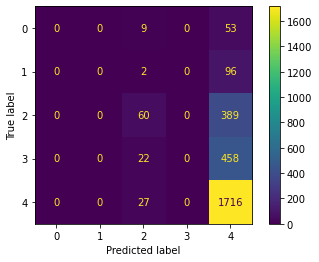

In [28]:
# Display confusion matrix.
cm_1 = confusion_matrix(true_labels, pred_labels_1, labels=clf_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=clf_1.classes_)
disp.plot()
plt.show()

In [29]:
accuracy = (cm_1[4,4] + cm_1[3,3] + cm_1[2,2] + cm_1[1,1] + cm_1[0,0])/len(y_hat_1)
accuracy

0.6271186440677966

Accuracy of model with hyperparameter tuning is 62.7%.

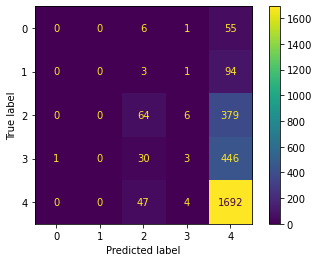

In [30]:
# Display confusion matrix.
cm_2 = confusion_matrix(true_labels, pred_labels_2, labels=clf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=clf_2.classes_)
disp.plot()
plt.show()

In [31]:
accuracy = (cm_2[4,4] + cm_2[3,3] + cm_2[2,2] + cm_2[1,1] + cm_2[0,0])/len(y_hat_2)
accuracy

0.6211158192090396

Accuracy of model without is 62.1%.  A slight improvement by tuning hyperparameters.

In [32]:
# Create lists to collect results.
gbm_n_estimator = []
gbm_tune_accuracy = []


# List to set criterion to test.

for n_est in range(1,100,10):
        
    # Fit model with hyperparameter above.
    clf  =  GradientBoostingClassifier(n_estimators=n_est,
                                   random_state=42)

    # Fit the training data to the model
    clf.fit(X_train.iloc[:, 0:539],
            Y_train,
            sample_weight=X_train['Conf'])
                        
    # Put together predictions based on set above.
    y_hat = clf.predict(X_validation.iloc[:, 0:539])
    
    # Put together confusion matrix.  Calculate accuracy from CM.
    true_labels = Y_validation
    pred_labels = y_hat
    cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)

    accuracy = (cm[0,0] + cm[1,1] + cm[2,2] + cm[3,3] + cm[4,4]) / len(Y_validation) * 100
                        
    # Append settings and accuracy to lists defined above.
    gbm_n_estimator.append(n_est)
    gbm_tune_accuracy.append(accuracy)
    print(n_est, accuracy)
                        
# Create a dataframe for the labels.

gbm_tune_df = {'N_Estimator':gbm_n_estimator,
               'Accuracy':gbm_tune_accuracy}
gbm_tune_df = pd.DataFrame(gbm_tune_df)

1 61.40536723163842
11 61.652542372881356
21 62.005649717514125
31 62.07627118644068
41 62.0409604519774
51 61.970338983050844
61 61.7231638418079
71 61.617231638418076
81 61.475988700564976
91 61.40536723163842


In [33]:
# Find row where accuracy is the highest.
gbm_tune_df.iloc[gbm_tune_df['Accuracy'].idxmax():gbm_tune_df['Accuracy'].idxmax()+1,]

,N_Estimator,Accuracy
3,31,62.076271


In [34]:
# Fit model with hyperparameter above.
clf_1  =  GradientBoostingClassifier(n_estimators=31,
                                   random_state=42)

# Fit the training data to the model
clf_1.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Fit a model with default settings
clf_2 = GradientBoostingClassifier(random_state=42)

# Fit the training data to the model
clf_2.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Put together predictions based on set above.
y_hat_1 = clf_1.predict(X_validation.iloc[:, 0:539])
y_hat_2 = clf_2.predict(X_validation.iloc[:, 0:539])
    
# Put together confusion matrix.  Calculate accuracy from CM.
true_labels = Y_validation
pred_labels_1 = y_hat_1
pred_labels_2 = y_hat_2

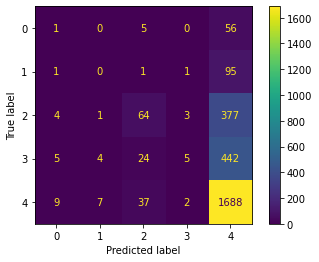

In [35]:
# Display confusion matrix.
cm_1 = confusion_matrix(true_labels, pred_labels_1, labels=clf_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=clf_1.classes_)
disp.plot()
plt.show()

In [36]:
accuracy = (cm_1[4,4] + cm_1[3,3] + cm_1[2,2] + cm_1[1,1] + cm_1[0,0])/len(true_labels)
accuracy

0.6207627118644068

Accuracy of model with tuned hyperparameters is 62%

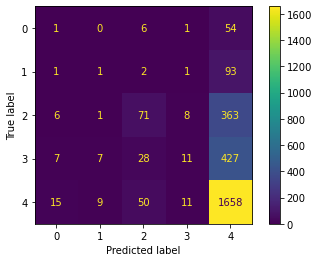

In [37]:
# Display confusion matrix.
cm_2 = confusion_matrix(true_labels, pred_labels_2, labels=clf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=clf_2.classes_)
disp.plot()
plt.show()

In [38]:
accuracy = (cm_2[4,4] + cm_2[3,3] + cm_2[2,2] + cm_2[1,1] + cm_2[0,0])/len(true_labels)
accuracy

0.6151129943502824

Accuracy of model without tuning is 61.5%.  Accuracy has improved through tuning.

In [39]:
# Do a simple GridSearch to try and find most ideal hyperparameters.  Load the results into a dataframe so we can
# extract settings with maximum accuracy.

# Create lists to collect results.
svc_tune_c = []
svc_tune_kernel =[]
svc_tune_gamma = []
svc_tune_accuracy = []

# List to set criterion to test.
kernel_list = ['linear','poly','rbf','sigmoid']
gamma_list = ['scale','auto']
c_list = [0.1,0.25,0.5,0.75,1.0]

for kernel_val in kernel_list:
            
    for gamma_val in gamma_list:
                
        for c_val in c_list:
                    
            # Fit model with hyperparameter above.
            clf = SVC(C=c_val,
                      gamma=gamma_val,
                      kernel=kernel_val,
                      random_state=42)

            # Fit the training data to the model
            clf.fit(X_train.iloc[:, 0:539],
                    Y_train,
                    sample_weight=X_train['Conf'])
                        
            # Put together predictions based on set above.
            y_hat = clf.predict(X_validation.iloc[:, 0:539])
    
            # Put together confusion matrix.  Calculate accuracy from CM.
            true_labels = Y_validation
            pred_labels = y_hat
            cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)

            accuracy = (cm[0,0] + cm[1,1] + cm[2,2] + cm[3,3] + cm[4,4]) / len(Y_validation) * 100
                        
            # Append settings and accuracy to lists defined above.
            svc_tune_c.append(c_val)
            svc_tune_kernel.append(kernel_val)
            svc_tune_gamma.append(gamma_val)
            svc_tune_accuracy.append(accuracy)
            print(kernel_val, gamma_val, c_val, accuracy)
                        
# Create a dataframe for the labels.

svc_tune_df = {'Kernel': svc_tune_kernel,
              'Gamma': svc_tune_gamma,
             'C': svc_tune_c,
             'Accuracy': svc_tune_accuracy}
svc_tune_df = pd.DataFrame(svc_tune_df)

linear scale 0.1 61.54661016949152
linear scale 0.25 61.54661016949152
linear scale 0.5 61.54661016949152
linear scale 0.75 61.54661016949152
linear scale 1.0 61.54661016949152
linear auto 0.1 61.54661016949152
linear auto 0.25 61.54661016949152
linear auto 0.5 61.54661016949152
linear auto 0.75 61.54661016949152
linear auto 1.0 61.54661016949152
poly scale 0.1 61.54661016949152
poly scale 0.25 61.54661016949152
poly scale 0.5 61.54661016949152
poly scale 0.75 61.54661016949152
poly scale 1.0 61.54661016949152
poly auto 0.1 61.54661016949152
poly auto 0.25 61.54661016949152
poly auto 0.5 61.54661016949152
poly auto 0.75 61.54661016949152
poly auto 1.0 61.54661016949152
rbf scale 0.1 61.54661016949152
rbf scale 0.25 61.54661016949152
rbf scale 0.5 61.54661016949152
rbf scale 0.75 61.54661016949152
rbf scale 1.0 61.54661016949152
rbf auto 0.1 61.54661016949152
rbf auto 0.25 61.54661016949152
rbf auto 0.5 61.54661016949152
rbf auto 0.75 61.54661016949152
rbf auto 1.0 61.54661016949152
sig

In [40]:
# Find row where accuracy is the highest.
svc_tune_df.iloc[svc_tune_df['Accuracy'].idxmax():svc_tune_df['Accuracy'].idxmax()+1,]

,Kernel,Gamma,C,Accuracy
32,sigmoid,scale,0.5,61.617232


In [41]:
# Fit model with hyperparameter above.
clf_1 = SVC(C=0.5,
            gamma='scale',
            kernel='sigmoid',
            random_state=42)

# Fit the training data to the model
clf_1.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Fit a model with default settings
clf_2 = SVC(random_state=42)

# Fit the training data to the model
clf_2.fit(X_train.iloc[:, 0:539],Y_train,sample_weight=X_train['Conf'])

# Put together predictions based on set above.
y_hat_1 = clf_1.predict(X_validation.iloc[:, 0:539])
y_hat_2 = clf_2.predict(X_validation.iloc[:, 0:539])
    
# Put together confusion matrix.  Calculate accuracy from CM.
true_labels = Y_validation
pred_labels_1 = y_hat_1
pred_labels_2 = y_hat_2

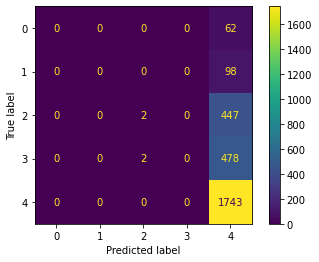

In [42]:
# Display confusion matrix.
cm_1 = confusion_matrix(true_labels, pred_labels_1, labels=clf_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=clf_1.classes_)
disp.plot()
plt.show()

In [43]:
accuracy = (cm_1[4,4] + cm_1[3,3] + cm_1[2,2] + cm_1[1,1] + cm_1[0,0])/len(true_labels)
accuracy

0.6161723163841808

Accuracy of model is 61.6%.  Doesn't seem to function any better than a null model.

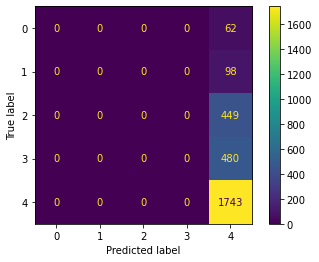

In [44]:
# Display confusion matrix.
cm_2 = confusion_matrix(true_labels, pred_labels_2, labels=clf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=clf_2.classes_)
disp.plot()
plt.show()

In [45]:
accuracy = (cm_2[4,4] + cm_2[3,3] + cm_2[2,2] + cm_2[1,1] + cm_2[0,0])/len(true_labels)
accuracy

0.6154661016949152

Model accuracy is 61.5%.  Performs just as well a null model.

In [46]:
# Create dictionary for class weights.
class_weight_dict = {4:train_df_positive['Label_Confidence'].mean()/train_df_positive['Label_Confidence'].mean(),
                3:train_df_neutral['Label_Confidence'].mean()/train_df_positive['Label_Confidence'].mean(),
                2:train_df_negative['Label_Confidence'].mean()/train_df_positive['Label_Confidence'].mean(),
                1:train_df_highly_negative['Label_Confidence'].mean()/train_df_positive['Label_Confidence'].mean(),
                0:train_df_highly_positive['Label_Confidence'].mean()/train_df_positive['Label_Confidence'].mean()}

class_weight_df = pd.DataFrame(class_weight_dict, index=[0])
class_weight_df

,4,3,2,1,0
0,1.0,0.849013,0.847266,0.736167,0.710174


In [47]:
# Fit model with hyperparameter above.
clf_1  =  RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                bootstrap='True',
                                random_state=42,
                                class_weight=class_weight_dict)

# Fit the training data to the model
clf_1.fit(X_train.iloc[:, 0:539],
          Y_train,
          sample_weight=X_train['Conf'])

# Fit a model with default settings
clf_2 = RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                bootstrap='True',
                                random_state=42)

# Fit the training data to the model
clf_2.fit(X_train.iloc[:, 0:539],
          Y_train,
          sample_weight=X_train['Conf'])

# Put together predictions based on set above.
y_hat_1 = clf_1.predict(X_validation.iloc[:, 0:539])
y_hat_2 = clf_2.predict(X_validation.iloc[:, 0:539])
    
# Put together confusion matrix.  Calculate accuracy from CM.
true_labels = Y_validation
pred_labels_1 = y_hat_1
pred_labels_2 = y_hat_2

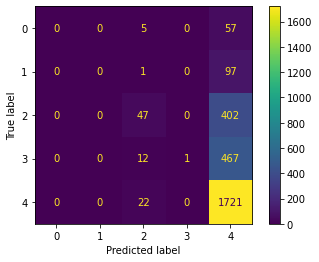

In [48]:
# Display confusion matrix.
cm_1 = confusion_matrix(true_labels, pred_labels_1, labels=clf_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=clf_1.classes_)
disp.plot()
plt.show()

In [49]:
accuracy = (cm_1[4,4] + cm_1[3,3] + cm_1[2,2] + cm_1[1,1] + cm_1[0,0])/len(true_labels)
accuracy

0.6246468926553672

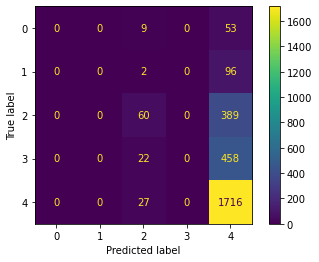

In [50]:
# Display confusion matrix.
cm_2 = confusion_matrix(true_labels, pred_labels_2, labels=clf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=clf_2.classes_)
disp.plot()
plt.show()

In [51]:
accuracy = (cm_2[4,4] + cm_2[3,3] + cm_2[2,2] + cm_2[1,1] + cm_2[0,0])/len(true_labels)
accuracy

0.6271186440677966

The model without class weighing is 62.7%, and the model with is 62.5%.  Model functioned slighly better without weighing.

## Import test dataset.

In [52]:
# Import test CSV file.

test_df = pd.read_csv('test_data_simplified_students.csv')
test_df.head()

,ID
0,772800977
1,373497125
2,361268494
3,483957657
4,698405955


In [53]:
prepared_train_1 = prepared_train.iloc[:,0:384]
prepared_train_2 = prepared_train.iloc[:,512:539]

prepared_train_filt = [prepared_train_1,prepared_train_2]
prepared_train_filt = pd.concat(prepared_train_filt, axis=1)

In [54]:
# create the model - Random forest
# this also may take a while on Colab for the same I/O issue, I stoped it after 20 minutes

clf_rf  =  RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_depth=10,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                bootstrap='True',
                                random_state=42)

clf_gbm = GradientBoostingClassifier(n_estimators=31,
                                   random_state=42)

# fit the training data to the model
clf_rf.fit(prepared_train.iloc[:,0:539],
           prepared_train['Label'],
           sample_weight=prepared_train['Conf'])

clf_gbm.fit(prepared_train.iloc[:,0:539],
            prepared_train['Label'],
            sample_weight=prepared_train['Conf'])

# loop through the test images

preds_rf = []
preds_gbm = []
global_test_features = []

for row in test_df.iterrows():
    # get the image file name
    file = "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)
    fv_mnpxlval = fd_mnpxlval(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, fv_mnpxlval])
    
    # scale features in the range (0-1) using the trainset scaler
    rescaled_feature = scaler.transform(global_feature.reshape(1,-1))
    
    #Remove unnecessary fields.
    prediction_rf = clf_rf.predict(rescaled_feature)[0]
    predition_gbm = clf_gbm.predict(rescaled_feature)[0]
    
    # update the list of predictions and feature vectors
    preds_rf.append(targetNames[prediction_rf])
    preds_gbm.append(targetNames[predition_gbm])
    global_test_features.append(rescaled_feature)



In [55]:
#Output RandomForest Predictions to a text file.
Label_rf = {'Label': preds_rf}
Label_rf = pd.DataFrame(Label_rf)

output_rf = pd.concat([test_df,Label_rf], axis=1)

output_rf.to_csv('32270208.csv', index=False)